In [1]:
#%pip install torch
#%pip install --upgrade transformers
#transformers=4.46.3
#!pip install transformers datasets
#!pip install --upgrade accelerate

In [2]:
import json
import pandas as pd
from pandas import read_json
import torch
import transformers

print(transformers.__version__)

C:\Users\darre\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.46.3


In [3]:
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [4]:
import torch 

torch.zeros(1).cuda()

print(torch.cuda.device_count())

if torch.cuda.is_available():
    print('GPU is available.')
else:
    print('No GPU found; using CPU.')
device = torch.cuda.current_device()
print(device)

1
GPU is available.
0


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, BertConfig
from torch.utils.data import DataLoader

BASE_MODEL = "bert-base-uncased"
LEARNING_RATE = 0.00001
max_length = 1024
BATCH_SIZE = 32
EPOCHS = 12
configuration = BertConfig.from_pretrained("bert-base-uncased")
#configuration.hidden_dropout_prob = 0.2
#configuration.attention_probs_dropout_prob = 0.1
configuration.num_labels=1
configuration.sinusoidal_pos_embds = True
configuration.activation = 'swish'

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, ignore_mismatched_sizes=True, config = configuration)
tokenizer.model_max_length = max_length
model.config.max_position_embeddings = max_length
model.base_model.embeddings.position_ids = torch.arange(max_length).expand((1, -1))
model.base_model.embeddings.token_type_ids = torch.zeros(max_length).expand((1, -1))
orig_pos_emb = model.base_model.embeddings.position_embeddings.weight
model.base_model.embeddings.position_embeddings.weight = torch.nn.Parameter(torch.cat((orig_pos_emb, orig_pos_emb)))
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import datasets
from datasets import Dataset
import pandas as pd
train = pd.read_json('rebalanced_fakepoints.json')
val = pd.read_json('Val.json')
test = pd.read_json('Test.json')

train_set = datasets.Dataset.from_pandas(train)
val_set = Dataset.from_pandas(val)
test_set = Dataset.from_pandas(test)
print('ok')

ok


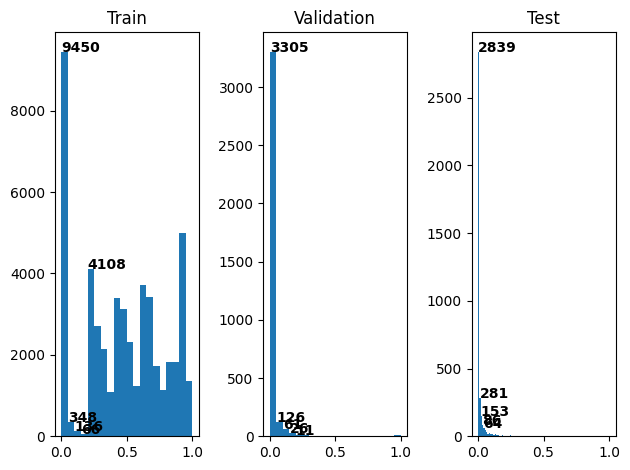

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Validation"); axs[2].set_title("Test"); 
train_distributions = axs[0].hist(train["label"], bins=20)
val_distributions = axs[1].hist(val["label"], bins=20)
test_distributions = axs[2].hist(test["label"], bins=100)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")


In [8]:
encoded_input = tokenizer.tokenize("Do not meddle in the affairs of wizards, for they are subtle and quick to anger.")
print(encoded_input)

['do', 'not', 'med', '##dle', 'in', 'the', 'affairs', 'of', 'wizards', ',', 'for', 'they', 'are', 'subtle', 'and', 'quick', 'to', 'anger', '.']


In [9]:
ds = {"train":train_set,
"val":val_set,
"test": test_set
}
def preprocess_function(examples):
    score = examples["label"]
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    examples["label"] = float(score)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text"])

Map: 100%|██████████| 3718/3718 [00:02<00:00, 1429.43 examples/s]


In [10]:
#!pip install -U scikit-learn scipy matplotlib

In [11]:
import numpy as np
#from datasets import load_metric
import torch

"""def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)"""
#metric = load_metric('mae')
'''
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}'''


'\ndef compute_metrics_for_regression(eval_pred):\n    logits, labels = eval_pred\n    labels = labels.reshape(-1, 1)\n\n    mse = mean_squared_error(labels, logits)\n    rmse = mean_squared_error(labels, logits, squared=False)\n    mae = mean_absolute_error(labels, logits)\n    r2 = r2_score(labels, logits)\n    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)\n\n    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}'

In [12]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="ygo_grifter/bert-base-uncased-finetuned",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    include_inputs_for_metrics = True,
    load_best_model_at_end=True,
    save_total_limit=1,
    weight_decay=0.01,
)

#metric_for_best_model= "mae",

f:\PROG_HUB\Apps\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using `include_inputs_for_metrics` is deprecated and will be removed in version 5 of 🤗 Transformers. Please use `include_for_metrics` list argument instead.


In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


def compute_metrics_for_regression(eval_pred):
    #print(eval_pred)
    logits, labels, dummy = eval_pred #had a gander at the output of eval pred (returned an object so i just googled what it returned), it returned three things, just gotta put one of them into a dummy var
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    mape = mean_absolute_percentage_error(labels, logits)

    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    #smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
    # Compute accuracy
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < (whatever e is less than
    accuracy = sum([1 for e in single_squared_errors if e < 0.15]) / len(single_squared_errors)

    return {"mse": mse, "mae": mae, "r2": r2, "mape": mape, "accuracy": accuracy}

In [14]:
#!pip install torchmetrics
from platform import python_version

print(python_version())
#import torch
import torch.nn as nn
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE
from sklearn.metrics import mean_squared_error
#!pip freeze > requirements_ipynb.txt
#!pip list

3.8.7


In [15]:
#import torch
import torch.nn as nn
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE
from sklearn.metrics import mean_squared_error
print(model)

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))
    
rmsle = RMSLELoss().to(device)
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch = None):
      labels = inputs.pop("labels") #after doing this, the inputs column will not have the labels column anymore (idk how, the names dont even match)
      outputs = model(**inputs)
      logits = outputs[0][:,0]
      loss = rmsle(labels, logits)
      return (loss, outputs) if return_outputs else loss

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["val"],
    compute_metrics=compute_metrics_for_regression
)


trainer.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

  0%|          | 0/18804 [00:00<?, ?it/s]f:\PROG_HUB\Apps\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  3%|▎         | 500/18804 [06:43<4:05:27,  1.24it/s]

{'loss': 0.1236, 'grad_norm': 2.2199947834014893, 'learning_rate': 9.73409912784514e-06, 'epoch': 0.32}


  5%|▌         | 1000/18804 [13:35<4:09:30,  1.19it/s]

{'loss': 0.0617, 'grad_norm': 3.4607815742492676, 'learning_rate': 9.46819825569028e-06, 'epoch': 0.64}


  8%|▊         | 1500/18804 [20:20<3:44:49,  1.28it/s]

{'loss': 0.0458, 'grad_norm': 1.421903133392334, 'learning_rate': 9.20229738353542e-06, 'epoch': 0.96}


                                                      
  8%|▊         | 1567/18804 [21:43<2:57:58,  1.61it/s]

{'eval_loss': 0.047011975198984146, 'eval_mse': 0.0040682521648705006, 'eval_mae': 0.030273111537098885, 'eval_r2': 0.3109791732553657, 'eval_mape': 7.243488311767578, 'eval_accuracy': 0.9955332216638749, 'eval_runtime': 29.6784, 'eval_samples_per_second': 120.694, 'eval_steps_per_second': 3.774, 'epoch': 1.0}


 11%|█         | 2000/18804 [27:26<3:37:22,  1.29it/s] 

{'loss': 0.0397, 'grad_norm': 2.3491618633270264, 'learning_rate': 8.936396511380559e-06, 'epoch': 1.28}


 13%|█▎        | 2500/18804 [33:59<4:11:22,  1.08it/s]

{'loss': 0.0339, 'grad_norm': 1.9049773216247559, 'learning_rate': 8.670495639225698e-06, 'epoch': 1.6}


 16%|█▌        | 3000/18804 [41:34<4:19:05,  1.02it/s]

{'loss': 0.0312, 'grad_norm': 1.6358559131622314, 'learning_rate': 8.404594767070838e-06, 'epoch': 1.91}


                                                      
 17%|█▋        | 3134/18804 [44:11<2:48:25,  1.55it/s]

{'eval_loss': 0.055320512503385544, 'eval_mse': 0.004783708602190018, 'eval_mae': 0.0475357249379158, 'eval_r2': 0.18980562696110992, 'eval_mape': 18.73448371887207, 'eval_accuracy': 0.9949748743718593, 'eval_runtime': 33.7453, 'eval_samples_per_second': 106.148, 'eval_steps_per_second': 3.319, 'epoch': 2.0}


 19%|█▊        | 3500/18804 [49:17<3:27:59,  1.23it/s] 

{'loss': 0.0283, 'grad_norm': 1.1511174440383911, 'learning_rate': 8.138693894915975e-06, 'epoch': 2.23}


 21%|██▏       | 4000/18804 [56:07<3:21:32,  1.22it/s]

{'loss': 0.0263, 'grad_norm': 2.3471927642822266, 'learning_rate': 7.872793022761115e-06, 'epoch': 2.55}


 24%|██▍       | 4500/18804 [1:03:35<3:51:04,  1.03it/s]

{'loss': 0.0249, 'grad_norm': 0.8406727910041809, 'learning_rate': 7.606892150606254e-06, 'epoch': 2.87}


                                                        
 25%|██▌       | 4701/18804 [1:07:15<2:50:54,  1.38it/s]

{'eval_loss': 0.03778091445565224, 'eval_mse': 0.003162054345011711, 'eval_mae': 0.019485920667648315, 'eval_r2': 0.4644576713671801, 'eval_mape': 3.3028886318206787, 'eval_accuracy': 0.9955332216638749, 'eval_runtime': 33.7374, 'eval_samples_per_second': 106.173, 'eval_steps_per_second': 3.32, 'epoch': 3.0}


 27%|██▋       | 5000/18804 [1:12:16<3:46:09,  1.02it/s] 

{'loss': 0.0229, 'grad_norm': 1.5876471996307373, 'learning_rate': 7.340991278451394e-06, 'epoch': 3.19}


 29%|██▉       | 5500/18804 [1:19:50<3:01:50,  1.22it/s]

{'loss': 0.0228, 'grad_norm': 1.124179482460022, 'learning_rate': 7.075090406296533e-06, 'epoch': 3.51}


 32%|███▏      | 6000/18804 [1:26:40<2:55:13,  1.22it/s]

{'loss': 0.0211, 'grad_norm': 0.9141553044319153, 'learning_rate': 6.8091895341416725e-06, 'epoch': 3.83}


                                                        
 33%|███▎      | 6268/18804 [1:30:49<2:14:51,  1.55it/s]

{'eval_loss': 0.03696171194314957, 'eval_mse': 0.0030979751609265804, 'eval_mae': 0.018635334447026253, 'eval_r2': 0.4753105205806625, 'eval_mape': 3.177704334259033, 'eval_accuracy': 0.9958123953098827, 'eval_runtime': 30.3912, 'eval_samples_per_second': 117.863, 'eval_steps_per_second': 3.685, 'epoch': 4.0}


 35%|███▍      | 6500/18804 [1:34:03<2:48:32,  1.22it/s] 

{'loss': 0.0199, 'grad_norm': 0.8519906997680664, 'learning_rate': 6.543288661986812e-06, 'epoch': 4.15}


 37%|███▋      | 7000/18804 [1:40:55<2:42:03,  1.21it/s]

{'loss': 0.0191, 'grad_norm': 1.1801228523254395, 'learning_rate': 6.277387789831951e-06, 'epoch': 4.47}


 40%|███▉      | 7500/18804 [1:47:48<2:34:16,  1.22it/s]

{'loss': 0.0191, 'grad_norm': 1.0648605823516846, 'learning_rate': 6.011486917677091e-06, 'epoch': 4.79}


                                                        
 42%|████▏     | 7835/18804 [1:52:55<1:57:54,  1.55it/s]

{'eval_loss': 0.03685063123703003, 'eval_mse': 0.003141236724331975, 'eval_mae': 0.017238391563296318, 'eval_r2': 0.46798345813056974, 'eval_mape': 2.067751169204712, 'eval_accuracy': 0.9952540480178671, 'eval_runtime': 30.2766, 'eval_samples_per_second': 118.309, 'eval_steps_per_second': 3.699, 'epoch': 5.0}


 43%|████▎     | 8000/18804 [1:55:23<3:04:54,  1.03s/it] 

{'loss': 0.0185, 'grad_norm': 0.6533326506614685, 'learning_rate': 5.74558604552223e-06, 'epoch': 5.11}


 45%|████▌     | 8500/18804 [2:03:09<2:21:28,  1.21it/s]

{'loss': 0.0174, 'grad_norm': 0.7958697080612183, 'learning_rate': 5.47968517336737e-06, 'epoch': 5.42}


 48%|████▊     | 9000/18804 [2:10:00<2:14:13,  1.22it/s]

{'loss': 0.0172, 'grad_norm': 2.412900686264038, 'learning_rate': 5.213784301212509e-06, 'epoch': 5.74}


                                                        
 50%|█████     | 9402/18804 [2:16:00<1:41:21,  1.55it/s]

{'eval_loss': 0.03549306467175484, 'eval_mse': 0.002993373665958643, 'eval_mae': 0.01644398644566536, 'eval_r2': 0.4930263298719587, 'eval_mape': 1.8511605262756348, 'eval_accuracy': 0.9955332216638749, 'eval_runtime': 30.2956, 'eval_samples_per_second': 118.235, 'eval_steps_per_second': 3.697, 'epoch': 6.0}


 51%|█████     | 9500/18804 [2:17:24<2:07:45,  1.21it/s] 

{'loss': 0.0165, 'grad_norm': 1.5807229280471802, 'learning_rate': 4.947883429057648e-06, 'epoch': 6.06}


 53%|█████▎    | 10000/18804 [2:24:18<2:02:46,  1.20it/s]

{'loss': 0.0162, 'grad_norm': 1.5439965724945068, 'learning_rate': 4.681982556902787e-06, 'epoch': 6.38}


 56%|█████▌    | 10500/18804 [2:31:11<1:54:03,  1.21it/s]

{'loss': 0.0158, 'grad_norm': 1.4201126098632812, 'learning_rate': 4.416081684747927e-06, 'epoch': 6.7}


                                                         
 58%|█████▊    | 10969/18804 [2:38:22<1:27:59,  1.48it/s]

{'eval_loss': 0.03530280292034149, 'eval_mse': 0.003010376589372754, 'eval_mae': 0.01601543091237545, 'eval_r2': 0.49014662416636934, 'eval_mape': 2.072901725769043, 'eval_accuracy': 0.9958123953098827, 'eval_runtime': 31.4538, 'eval_samples_per_second': 113.881, 'eval_steps_per_second': 3.561, 'epoch': 7.0}


 58%|█████▊    | 11000/18804 [2:38:49<1:51:24,  1.17it/s] 

{'loss': 0.0161, 'grad_norm': 1.877867341041565, 'learning_rate': 4.150180812593065e-06, 'epoch': 7.02}


 61%|██████    | 11500/18804 [2:45:33<1:37:48,  1.24it/s]

{'loss': 0.0149, 'grad_norm': 1.0617084503173828, 'learning_rate': 3.884279940438205e-06, 'epoch': 7.34}


 64%|██████▍   | 12000/18804 [2:52:23<1:34:05,  1.21it/s]

{'loss': 0.0145, 'grad_norm': 1.8270632028579712, 'learning_rate': 3.618379068283344e-06, 'epoch': 7.66}


 66%|██████▋   | 12500/18804 [2:59:32<1:39:44,  1.05it/s]

{'loss': 0.0145, 'grad_norm': 1.255946397781372, 'learning_rate': 3.3524781961284837e-06, 'epoch': 7.98}


                                                         
 67%|██████▋   | 12536/18804 [3:00:35<1:10:29,  1.48it/s]

{'eval_loss': 0.0348774753510952, 'eval_mse': 0.0029322966001927853, 'eval_mae': 0.015756865963339806, 'eval_r2': 0.5033706840629996, 'eval_mape': 1.836641788482666, 'eval_accuracy': 0.9958123953098827, 'eval_runtime': 32.4753, 'eval_samples_per_second': 110.299, 'eval_steps_per_second': 3.449, 'epoch': 8.0}


 69%|██████▉   | 13000/18804 [3:07:16<1:29:06,  1.09it/s] 

{'loss': 0.0145, 'grad_norm': 0.5594944357872009, 'learning_rate': 3.086577323973623e-06, 'epoch': 8.3}


 72%|███████▏  | 13500/18804 [3:14:27<1:13:17,  1.21it/s]

{'loss': 0.0138, 'grad_norm': 2.005363941192627, 'learning_rate': 2.8206764518187626e-06, 'epoch': 8.62}


 74%|███████▍  | 14000/18804 [3:21:43<1:03:39,  1.26it/s]

{'loss': 0.0136, 'grad_norm': 0.7252641916275024, 'learning_rate': 2.5547755796639016e-06, 'epoch': 8.93}


                                                         
 75%|███████▌  | 14103/18804 [3:23:40<50:31,  1.55it/s]

{'eval_loss': 0.0349891223013401, 'eval_mse': 0.002980752382427454, 'eval_mae': 0.016187027096748352, 'eval_r2': 0.4951638937676549, 'eval_mape': 2.267552137374878, 'eval_accuracy': 0.9958123953098827, 'eval_runtime': 30.3659, 'eval_samples_per_second': 117.961, 'eval_steps_per_second': 3.688, 'epoch': 9.0}


 77%|███████▋  | 14500/18804 [3:29:02<59:56,  1.20it/s]   

{'loss': 0.013, 'grad_norm': 0.6551762819290161, 'learning_rate': 2.288874707509041e-06, 'epoch': 9.25}


 80%|███████▉  | 15000/18804 [3:35:54<53:10,  1.19it/s]  

{'loss': 0.0132, 'grad_norm': 1.1469916105270386, 'learning_rate': 2.02297383535418e-06, 'epoch': 9.57}


 82%|████████▏ | 15500/18804 [3:42:50<45:17,  1.22it/s]

{'loss': 0.0134, 'grad_norm': 0.814033031463623, 'learning_rate': 1.7570729631993195e-06, 'epoch': 9.89}


                                                       
 83%|████████▎ | 15670/18804 [3:45:38<34:22,  1.52it/s]

{'eval_loss': 0.034898485988378525, 'eval_mse': 0.002958460710942745, 'eval_mae': 0.01572374254465103, 'eval_r2': 0.49893938690778394, 'eval_mape': 1.692996859550476, 'eval_accuracy': 0.9955332216638749, 'eval_runtime': 30.7371, 'eval_samples_per_second': 116.537, 'eval_steps_per_second': 3.644, 'epoch': 10.0}


 85%|████████▌ | 16000/18804 [3:50:15<41:19,  1.13it/s]  

{'loss': 0.0129, 'grad_norm': 1.6386492252349854, 'learning_rate': 1.4911720910444587e-06, 'epoch': 10.21}


 88%|████████▊ | 16500/18804 [3:57:27<34:23,  1.12it/s]

{'loss': 0.0127, 'grad_norm': 1.4858274459838867, 'learning_rate': 1.225271218889598e-06, 'epoch': 10.53}


 90%|█████████ | 17000/18804 [4:04:58<26:45,  1.12it/s]

{'loss': 0.0122, 'grad_norm': 1.0937435626983643, 'learning_rate': 9.593703467347374e-07, 'epoch': 10.85}


                                                       
 92%|█████████▏| 17237/18804 [4:08:45<16:27,  1.59it/s]

{'eval_loss': 0.03437517583370209, 'eval_mse': 0.0029041124507784843, 'eval_mae': 0.015154198743402958, 'eval_r2': 0.5081440537754705, 'eval_mape': 1.4769474267959595, 'eval_accuracy': 0.9955332216638749, 'eval_runtime': 28.6728, 'eval_samples_per_second': 124.927, 'eval_steps_per_second': 3.906, 'epoch': 11.0}


 93%|█████████▎| 17500/18804 [4:12:12<16:56,  1.28it/s]  

{'loss': 0.0125, 'grad_norm': 0.5923874974250793, 'learning_rate': 6.934694745798768e-07, 'epoch': 11.17}


 96%|█████████▌| 18000/18804 [4:18:43<10:26,  1.28it/s]

{'loss': 0.012, 'grad_norm': 0.6757121682167053, 'learning_rate': 4.27568602425016e-07, 'epoch': 11.49}


 98%|█████████▊| 18500/18804 [4:25:13<03:56,  1.28it/s]

{'loss': 0.0124, 'grad_norm': 1.2997153997421265, 'learning_rate': 1.616677302701553e-07, 'epoch': 11.81}


                                                       
100%|██████████| 18804/18804 [4:29:42<00:00,  1.63it/s]

{'eval_loss': 0.034522973001003265, 'eval_mse': 0.0029262027237564325, 'eval_mae': 0.015159040689468384, 'eval_r2': 0.5044027376850128, 'eval_mape': 1.5253442525863647, 'eval_accuracy': 0.9955332216638749, 'eval_runtime': 28.4799, 'eval_samples_per_second': 125.773, 'eval_steps_per_second': 3.933, 'epoch': 12.0}


100%|██████████| 18804/18804 [4:29:45<00:00,  1.63it/s]

{'train_runtime': 16185.0694, 'train_samples_per_second': 37.16, 'train_steps_per_second': 1.162, 'train_loss': 0.02303015709024773, 'epoch': 12.0}


100%|██████████| 18804/18804 [4:29:45<00:00,  1.16it/s]


TrainOutput(global_step=18804, training_loss=0.02303015709024773, metrics={'train_runtime': 16185.0694, 'train_samples_per_second': 37.16, 'train_steps_per_second': 1.162, 'total_flos': 7.912204615655424e+16, 'train_loss': 0.02303015709024773, 'epoch': 12.0})

In [16]:
model.save_pretrained("ygo_nlp_Version2_RMSLE")

In [17]:
trainer.eval_dataset=ds["test"]
trainer.evaluate()

100%|██████████| 117/117 [00:29<00:00,  4.01it/s]


{'eval_loss': 0.03894811123609543,
 'eval_mse': 0.0034634601324796677,
 'eval_mae': 0.017016448080539703,
 'eval_r2': 0.4404444289734515,
 'eval_mape': 1.6302573680877686,
 'eval_accuracy': 0.9935449166218397,
 'eval_runtime': 29.4396,
 'eval_samples_per_second': 126.292,
 'eval_steps_per_second': 3.974,
 'epoch': 12.0}

In [18]:
predictions = trainer.predict(ds["test"])

100%|██████████| 117/117 [00:29<00:00,  4.00it/s]


In [19]:
comparison = []
for i in range(len(predictions[0])):
    comparison.append([predictions[0][i][0], ds["test"]["label"][i]])

print(comparison)

[[0.004374835, 0.0044], [-0.0016322304, 0.0019], [0.01100334, 0.010100000000000001], [-0.00044002384, 0.0005], [0.0074779694, 0.006900000000000001], [0.0012329537, 0.0045000000000000005], [0.020917116, 0.0035], [0.003842061, 0.0057], [0.003727303, 0.0021000000000000003], [0.0066953762, 0.006200000000000001], [0.004190281, 0.0047], [0.0025253263, 0.0012000000000000001], [-0.001009766, 0.0019], [0.011580132, 0.0274], [0.006296664, 0.0021000000000000003], [-0.00017279596, 0.0011], [0.004543156, 0.0049], [0.008040176, 0.009600000000000001], [0.014191881, 0.035500000000000004], [0.004699395, 0.0026000000000000003], [0.013353394, 0.0229], [0.0021316102, 0.0018000000000000002], [0.023683235, 0.0044], [-0.019305743, 0.1047], [0.0062757097, 0.0032], [0.0032522958, 0.0027], [0.00013188366, 0.009300000000000001], [0.0003862644, 0.0016], [0.0034544487, 0.0024000000000000002], [0.0015641425, 0.0068000000000000005], [0.00068120984, 0.0019], [-0.0016250047, 0.0037], [0.00117257, 0.0018000000000000002

In [20]:
 print(test_set[10])

{'text': "[SEP]AAAtype Effect Monster [SEP]AAAhumanReadableCardType Effect Monster [SEP]AAAframeType effect [SEP]AAAdesc You can Tribute this card; Special Summon 1 archetypal monster from your hand or Graveyard in face-up Defense Position, except card with this name. [SEP]AAArace Spellcaster [SEP]AAAtypeline ['Spellcaster', 'Effect'] [SEP]AAAatk 900.0 [SEP]AAAdef 100.0 [SEP]AAAlevel 2.0 [SEP]AAAattribute LIGHT [SEP]AAAscale nan [SEP]AAAlinkmarkers None [SEP]AAAbanlist_info nan [SEP]AAAcard_sets.set_rarity Super Rare [SEP]AAAcard_sets.set_rarity_code (SR) [SEP]AAAcard_sets.set_edition Unlimited [SEP]AAAbanlist_info.ban_tcg nan [SEP]AAAbanlist_info.ban_ocg nan", 'label': 0.0047}


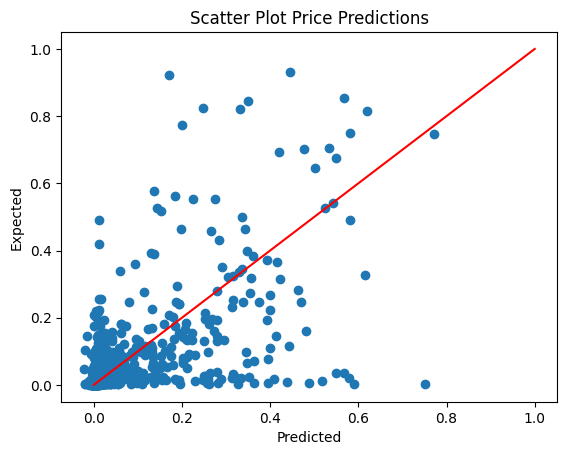

In [21]:
x = []
y = []
for i in range(len(comparison)):
    if comparison[i][1] <1: #expected value range
        y.append(comparison[i][1])
        x.append(comparison[i][0])

x_line = np.linspace(0,1)  # generate 100 points between 0 and 1
y_line = x_line

# Plot the straight line
plt.plot(x_line, y_line, color='red', label='y = x')
plt.scatter(x, y)
plt.title("Scatter Plot Price Predictions")
plt.xlabel("Predicted")
plt.ylabel("Expected")

# Show the plot
plt.show()
